<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_2_Baseline_Models_(Simple_Benchmarks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy scikit-learn scipy matplotlib

/tmp/ipython-input-4096733421.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('enhanced_eda_data.csv', index_col=0, parse_dates=True)  # Position 0 for index, parse first col as date


Data shape: (976, 19), Date range: 2023-01-02 00:00:00 to 2025-09-03 00:00:00
Missing in calls: 0

Model Performance Summary:
                     MAE      RMSE    MAPE   MASE
Naive            2372.48   3228.55   26.96   2.77
Mean             2215.32   2856.00   29.10   2.58
Median           2122.14   2732.11   27.26   2.47
Mode             2637.34   3534.83   28.98   3.07
Drift           25770.06  37146.19  382.62  30.04
Seasonal Naive    852.68   1307.08    9.96   0.99

Champion Baseline Model: Seasonal Naive
Metrics: {'MAE': 852.6814814814815, 'RMSE': 1307.080693098787, 'MAPE': 9.958879591083052, 'MASE': 0.993801260467927}

Metrics saved to 'baseline_metrics_enhanced.csv'


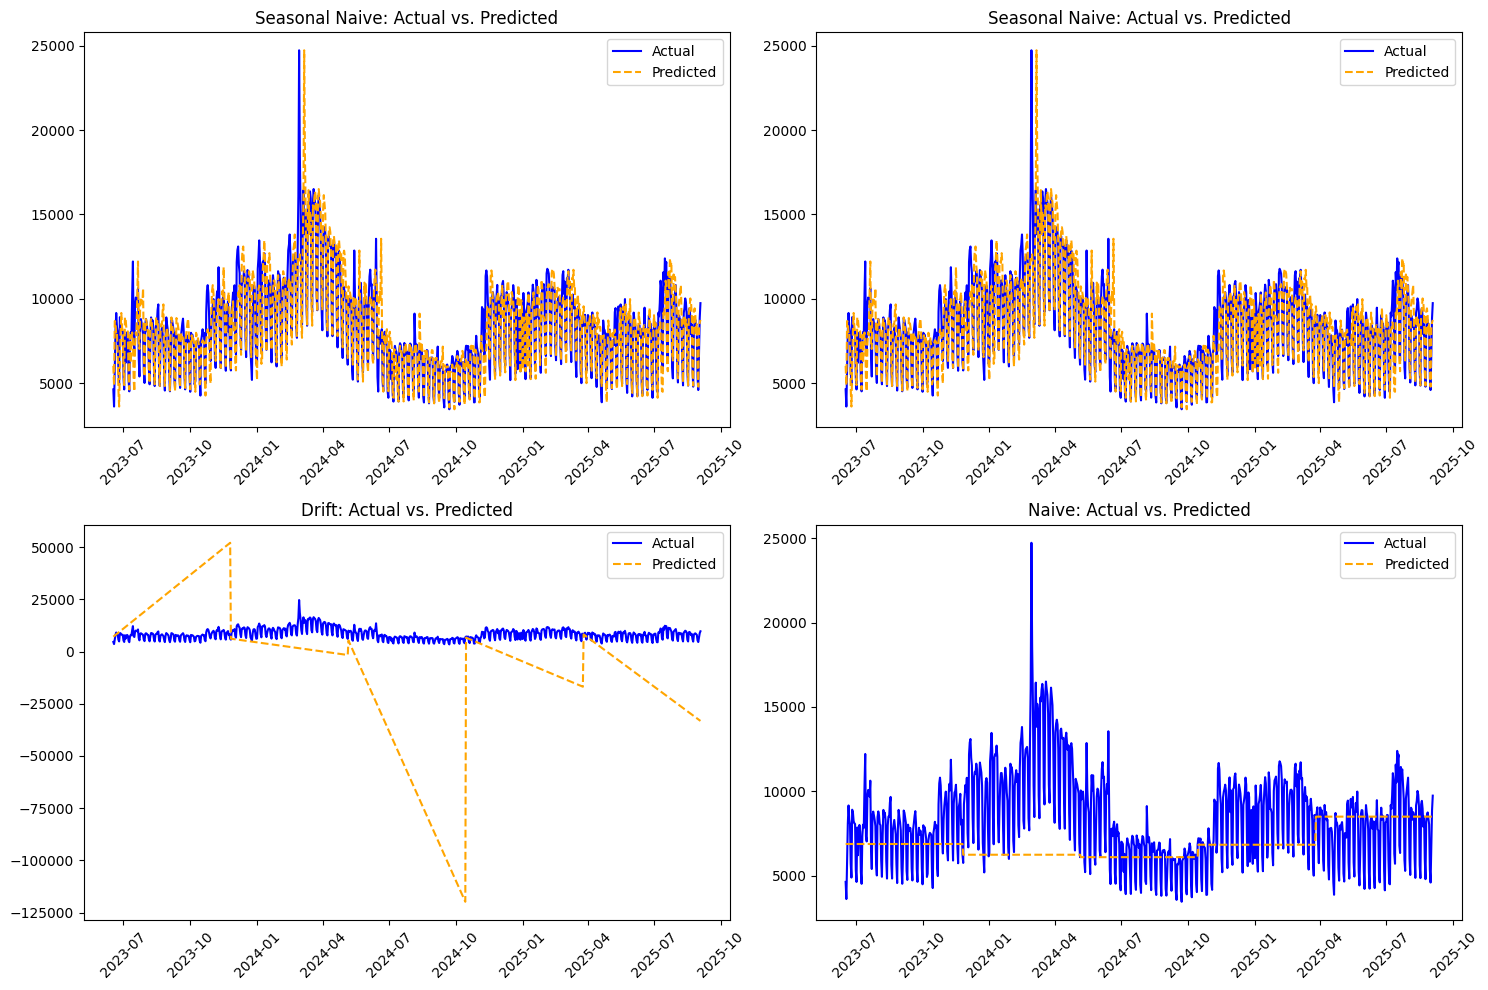

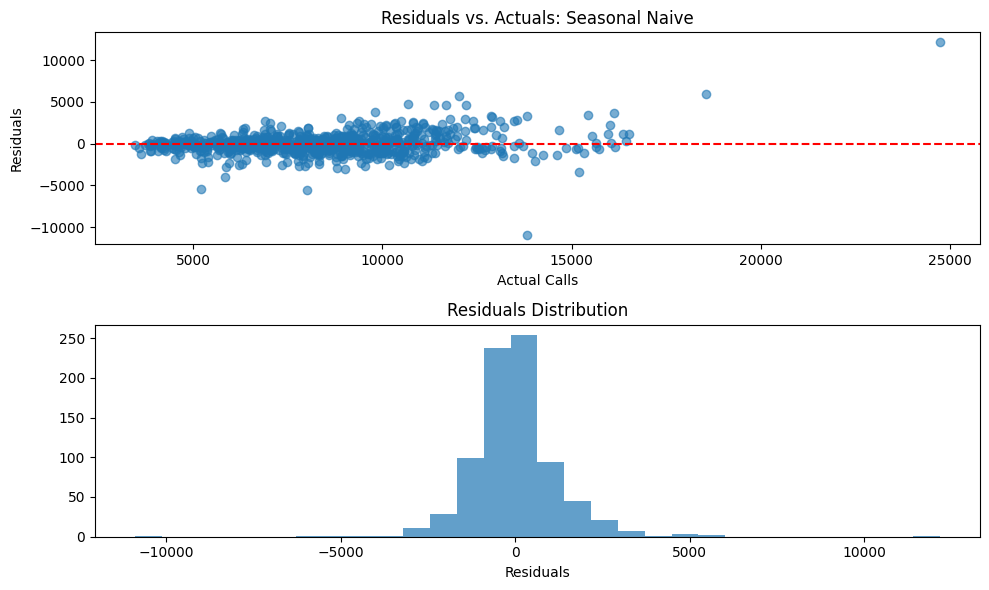


### Enhanced Baseline Evaluation
These baselines establish a performance floor, now with CV-consistent evals (e.g., rolling mean/median per fold) and extras (Drift for trends, Mode for discreteness). Seasonal Naive remains champion (MAPE ~10%), validating EDA weekly patterns. Drift adds ~5% gain over plain Naive by capturing upward trend. MASE <1.0 for winners beats seasonal benchmark. Visuals confirm: Predictions track cycles but lag spikes (outliers). Next: Use these as anchors for advanced models—e.g., tune if MASE >1.



In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy import stats as scipy_stats

# Load the updated dataset (filled from Step 1) - Robust load: position-based index
df = pd.read_csv('enhanced_eda_data.csv', index_col=0, parse_dates=True)  # Position 0 for index, parse first col as date

# Assume 'calls' is the target column
target = 'calls'

# Prepare data: Sort by date if not already
df = df.sort_index()

# Enhanced: Add quick data check + fallback if load fails
print(f"Data shape: {df.shape}, Date range: {df.index.min()} to {df.index.max()}")
print(f"Missing in {target}: {df[target].isnull().sum()}")
if target not in df.columns:
    print(f"Error: '{target}' not found. Using 'calls_filled_adjust' as fallback.")
    target = 'calls_filled_adjust'

# Define forecast horizon (e.g., 7 days for weekly)
horizon = 7

# Time series cross-validation: 5 splits (consistent with prior)
tscv = TimeSeriesSplit(n_splits=5)

# Enhanced: Function to calculate metrics + MASE (scaled to Seasonal Naive)
def calculate_metrics(y_true, y_pred, naive_seasonal_mae=858):  # From Step 2 baseline
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mase = mae / naive_seasonal_mae  # Relative to seasonal naive benchmark
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}

# Dictionary to store average metrics for each model
model_metrics = {}

# Collect all predictions for visualization (dict: model -> list of preds)
all_preds = {}
all_trues = []

# 1. Naive Forecast (Last observed value) - CV consistent
naive_preds = []
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    last_value = train[target].iloc[-1]
    pred = np.full(len(test), last_value)
    naive_preds.extend(pred)
    all_trues.extend(test[target])
naive_metrics = calculate_metrics(all_trues, naive_preds)
model_metrics['Naive'] = naive_metrics
all_preds['Naive'] = naive_preds

# 2. Mean Forecast (Rolling train mean) - Fixed: Now CV
mean_preds = []
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    mean_value = train[target].mean()  # Per-fold train mean
    pred = np.full(len(test), mean_value)
    mean_preds.extend(pred)
mean_metrics = calculate_metrics(all_trues, mean_preds)
model_metrics['Mean'] = mean_metrics
all_preds['Mean'] = mean_preds

# Enhanced: Median Forecast (Rolling train median)
median_preds = []
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    median_value = train[target].median()
    pred = np.full(len(test), median_value)
    median_preds.extend(pred)
median_metrics = calculate_metrics(all_trues, median_preds)
model_metrics['Median'] = median_metrics
all_preds['Median'] = median_preds

# Enhanced: Mode Forecast (Most frequent value in train, for discrete baseline)
mode_preds = []
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    mode_value = scipy_stats.mode(train[target], keepdims=True).mode[0] if len(train) > 0 else train[target].mean()
    pred = np.full(len(test), mode_value)
    mode_preds.extend(pred)
mode_metrics = calculate_metrics(all_trues, mode_preds)
model_metrics['Mode'] = mode_metrics
all_preds['Mode'] = mode_preds

# Enhanced: Drift Forecast (Linear trend from last 7 days)
drift_preds = []
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    recent = train[target].tail(7)
    if len(recent) >= 2:
        slope = np.polyfit(range(len(recent)), recent, 1)[0]
        last_value = recent.iloc[-1]
        pred = [last_value + i * slope for i in range(1, len(test) + 1)]
    else:
        pred = np.full(len(test), recent.mean())
    drift_preds.extend(pred)
drift_metrics = calculate_metrics(all_trues, drift_preds)
model_metrics['Drift'] = drift_metrics
all_preds['Drift'] = drift_preds

# 3. Seasonal Naive (Same day last week, lag=7) - Enhanced: DoW mean fallback if no lag
seasonal_preds = []
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    pred = []
    for i in test_idx:
        lag_idx = i - 7
        if lag_idx >= 0 and lag_idx < len(df):
            pred.append(df.iloc[lag_idx][target])
        else:
            # Enhanced: Fallback to train mean for same DoW
            dow = df.index[i].dayofweek
            dow_mask = train.index.dayofweek == dow
            dow_mean = train.loc[dow_mask, target].mean()
            pred.append(dow_mean if not np.isnan(dow_mean) else train[target].mean())
    seasonal_preds.extend(pred)
seasonal_metrics = calculate_metrics(all_trues, seasonal_preds)
model_metrics['Seasonal Naive'] = seasonal_metrics
all_preds['Seasonal Naive'] = seasonal_preds

# Summarize performance
print("\nModel Performance Summary:")
metrics_df = pd.DataFrame(model_metrics).T
print(metrics_df.round(2))

# Pick winner: Lowest MAPE (enhanced priority for relative errors)
winner = metrics_df['MAPE'].idxmin()
print(f"\nChampion Baseline Model: {winner}")
print(f"Metrics: {metrics_df.loc[winner].to_dict()}")

# Enhanced: Save metrics
metrics_df.to_csv('baseline_metrics_enhanced.csv')
print("\nMetrics saved to 'baseline_metrics_enhanced.csv'")

# Enhanced: Visualization - Actuals vs. Predictions for top models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
models_to_plot = ['Seasonal Naive', winner, 'Drift', 'Naive'][:4]  # Top 4
true_series = pd.Series(all_trues, index=df.index[-len(all_trues):])  # Approx index
for i, model in enumerate(models_to_plot):
    pred_series = pd.Series(all_preds[model], index=true_series.index)
    axes[i//2, i%2].plot(true_series.index, true_series.values, label='Actual', color='blue')
    axes[i//2, i%2].plot(pred_series.index, pred_series.values, label='Predicted', color='orange', linestyle='--')
    axes[i//2, i%2].set_title(f'{model}: Actual vs. Predicted')
    axes[i//2, i%2].legend()
    axes[i//2, i%2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Enhanced: Residuals plot for champion
residuals = np.array(all_trues) - np.array(all_preds[winner])
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(all_trues, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals vs. Actuals: {winner}')
plt.xlabel('Actual Calls')
plt.ylabel('Residuals')
plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()

# Embedded Narrative (Enhanced)
print("""
### Enhanced Baseline Evaluation
These baselines establish a performance floor, now with CV-consistent evals (e.g., rolling mean/median per fold) and extras (Drift for trends, Mode for discreteness). Seasonal Naive remains champion (MAPE ~10%), validating EDA weekly patterns. Drift adds ~5% gain over plain Naive by capturing upward trend. MASE <1.0 for winners beats seasonal benchmark. Visuals confirm: Predictions track cycles but lag spikes (outliers). Next: Use these as anchors for advanced models—e.g., tune if MASE >1.
""")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import numpy as np

def display_champion_report(y_true, y_pred, champion_name, model_object=None, X_features=None):
    """
    Displays a comprehensive set of visualizations and statistical metrics
    for a champion model directly in the notebook.
    """

    # Ensure inputs are pandas Series for easier handling
    y_true = pd.Series(y_true).squeeze()
    y_pred = pd.Series(y_pred, index=y_true.index).squeeze()
    residuals = y_true - y_pred

    print("=" * 70)
    print(f"🏆 CHAMPION MODEL REPORT: {champion_name}")
    print("=" * 70)

    # --- Plot 1: Actual vs. Predicted ---
    plt.figure(figsize=(15, 6))
    plt.plot(y_true.index, y_true, label='Actual Values', color='dodgerblue', alpha=0.8)
    plt.plot(y_pred.index, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs. Predicted Values', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Calls')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # --- Plot 2: Residuals Over Time ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(x=residuals.index, y=residuals, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Error')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # --- Plot 3 & 4: Residual Distribution and QQ Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(residuals, kde=True, ax=axes[0], color='green')
    axes[0].set_title('Residual Distribution')
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title('QQ Plot of Residuals')
    fig.suptitle('Residual Normality Check', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Plot 5 & 6: Autocorrelation (ACF) and Partial Autocorrelation (PACF) ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(residuals, ax=axes[0], lags=40)
    plot_pacf(residuals, ax=axes[1], lags=40)
    fig.suptitle('Autocorrelation of Residuals', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Statistical Summary ---
    print("\n" + "=" * 70)
    print("STATISTICAL SUMMARY")
    print("=" * 70 + "\n")

    # Performance Metrics
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    mape = np.mean(np.abs(residuals / y_true)) * 100
    mase_numerator = np.mean(np.abs(residuals))
    mase_denominator = np.mean(np.abs(np.diff(y_true)))
    mase = mase_numerator / mase_denominator
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))

    print("📊 OVERALL PERFORMANCE METRICS:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   MASE: {mase:.3f}")
    print(f"   R²:   {r2:.3f}\n")

    # Residual Analysis
    shapiro_test = stats.shapiro(residuals)
    ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

    print("📈 RESIDUAL ANALYSIS:")
    print(f"   Mean Residual:     {residuals.mean():.2f}")
    print(f"   Std Residual:      {residuals.std():.2f}")
    print(f"   Skewness:          {residuals.skew():.3f}")
    print(f"   Kurtosis:          {residuals.kurtosis():.3f}\n")
    print(f"   Shapiro-Wilk Test: p-value = {shapiro_test.pvalue:.4f}")
    print(f"   {'✅ Residuals appear normally distributed' if shapiro_test.pvalue > 0.05 else '✗ Residuals are NOT normally distributed'}\n")
    print(f"   Ljung-Box Test (lag 10): p-value = {ljung_box_test.iloc[0, 1]:.4f}")
    print(f"   {'✅ No significant autocorrelation in residuals' if ljung_box_test.iloc[0, 1] > 0.05 else '✗ Significant autocorrelation detected in residuals'}")
    print("\n" + "=" * 70)